In [1]:
from datetime import datetime
from pathlib import Path

import pandas as pd

ROOT_DIR = Path.cwd().parent.parent
DATA_DIR = ROOT_DIR / "data"
TRANSLATION_DIR = ROOT_DIR / "notebooks" / "diego" / "input" / "column_translation"

In [2]:
df_exit_pages = pd.read_csv(
    DATA_DIR / "Export _ Ausstiegsseiten _ 3. August 2022 – 20. März 2023.csv",
    encoding="utf-16le",
)
df_exit_pages.name = "Exit Pages"
df_entry_pages = pd.read_csv(
    DATA_DIR / "Export _ Einstiegsseiten _ 3. August 2022 – 20. März 2023.csv",
    encoding="utf-16le",
)
df_entry_pages.name = "Entry Pages"
df_search_engines = pd.read_csv(
    DATA_DIR / "Export _ Suchmaschinen _ 3. August 2022 – 20. März 2023.csv",
    encoding="utf-16le",
)
df_search_engines.name = "Search Engines"
df_channel_type = pd.read_csv(
    DATA_DIR / "Export _ Kanaltyp _ 3. August 2022 – 20. März 2023 (1).csv",
    encoding="utf-16le",
)
df_channel_type.name = "Channel Type"
df_main_table = pd.read_csv(
    DATA_DIR / "Export _  _ 3. August 2022 – 8. März 2023.csv", encoding="utf-16le"
)
df_main_table.name = "Main Table"

df_exit_pages_column_translations = pd.read_csv(
    TRANSLATION_DIR / "exit_pages_columns_translation.csv", sep="\t"
)
df_entry_pages_column_translations = pd.read_csv(
    TRANSLATION_DIR / "entry_pages_columns_translation.csv", sep="\t"
)
df_search_engines_column_translations = pd.read_csv(
    TRANSLATION_DIR / "search_engines_columns_translation.csv", sep="\t"
)
df_channel_type_column_translations = pd.read_csv(
    TRANSLATION_DIR / "channel_type_columns_translation.csv", sep="\t"
)

# replace column names with translated ones
df_exit_pages.columns = df_exit_pages_column_translations["English"]
df_entry_pages.columns = df_entry_pages_column_translations["English"]
df_search_engines.columns = df_search_engines_column_translations["English"]
df_channel_type.columns = df_channel_type_column_translations["English"]

/tmp/ipykernel_25531/704195051.py:21: DtypeWarning: Columns (38,40,162,169,170,171,172,234,241,245,246,247,248,252,253,263,292,299,303,304,318,333,348,351,355,356,370,385,400,415,430,445,456,473,518,523,525,527,529,533,537,542,544,546,550,557,563,610,660,666,671,673,677,681,682,684,687,688,689,690,692,693,696,698,699,701,703,704,705,707,708,711,713,714,716,718,719,720,722,723,726,728,729,731,733,734,735,737,738,741,743,744,746,748,749,750,752,753,756,758,759,761,763,764,765,767,768,771,773,774,776,778,779,780,782,783,786,788,789,791,793,794,795,797,798,801,802,803,804,806,807,808,810,811,814,816,817,819,821,822,823,825,826,829,831,832,834,836,837,838,840,841,844,846,847,849,851,852,853,855,856,859,861,862,863,864,866,867,868,870,871,874,876,877,879,881,882,883,885,886,889,891,892,894,896,897,898,900,901,904,906,907,909,911,912,913,915,916,919,921,922,924,926,930,933,935,937,939,941,943,945,949,952,956,957,959,961,963,965,967,969,970,971,973,974,976,978,981,982,984,986,987,988,990,991,9

In [3]:
df_main_table_unpivot = pd.melt(
    df_main_table,
    id_vars=["idVisit", "visitIp", "visitorId", "fingerprint"],
    value_vars=[
        col
        for col in df_main_table.columns
        if col not in ["idVisit", "visitIp", "visitorId", "fingerprint"]
    ],
)
df_main_table_unpivot.dropna(subset=["value"], inplace=True)
# df_main_table_unpivot.to_csv("output/main_table_unpivot.csv", index=False)

In [96]:
def check_column_name_for_url(text):
    for col in df_main_table.columns:
        if text in col:
            # if col.startswith(text):
            print(col)


# check_column_name_for_url("action")

In [82]:
df = df_main_table[
    [
        "deviceType",
        "deviceBrand",
        "browserName",
        "languageCode",
        "goalConversions",
        "visitDuration",
    ]
]

for i, row in df.iterrows():
    if row["visitDuration"] > 60 * 30:
        df.loc[i, "visitDuration"] = 1800

In [83]:
# remove visitDuration equal to 0
df = df[df["visitDuration"] > 0]

# df.visitDuration.describe()
y = df["visitDuration"] > 221
y = y.to_numpy()

# one hot encoding
df = pd.get_dummies(
    df, columns=["deviceType", "deviceBrand", "browserName", "languageCode"]
)
df.drop(columns=["goalConversions", "visitDuration"], inplace=True)
X = df.to_numpy()

In [84]:
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X)

clf.predict_proba(X)


clf.score(X, y)

0.75

In [95]:
data = []
for i, col in enumerate(df.columns):
    # print(col, clf.coef_[0][i])
    data.append({"feature": col, "coef": clf.coef_[0][i]})
df_coef = pd.DataFrame(data)
df_coef.sort_values(by="coef", ascending=False, inplace=True)
df_coef.to_csv("output/coef.csv", index=False)

<AxesSubplot: xlabel='feature'>

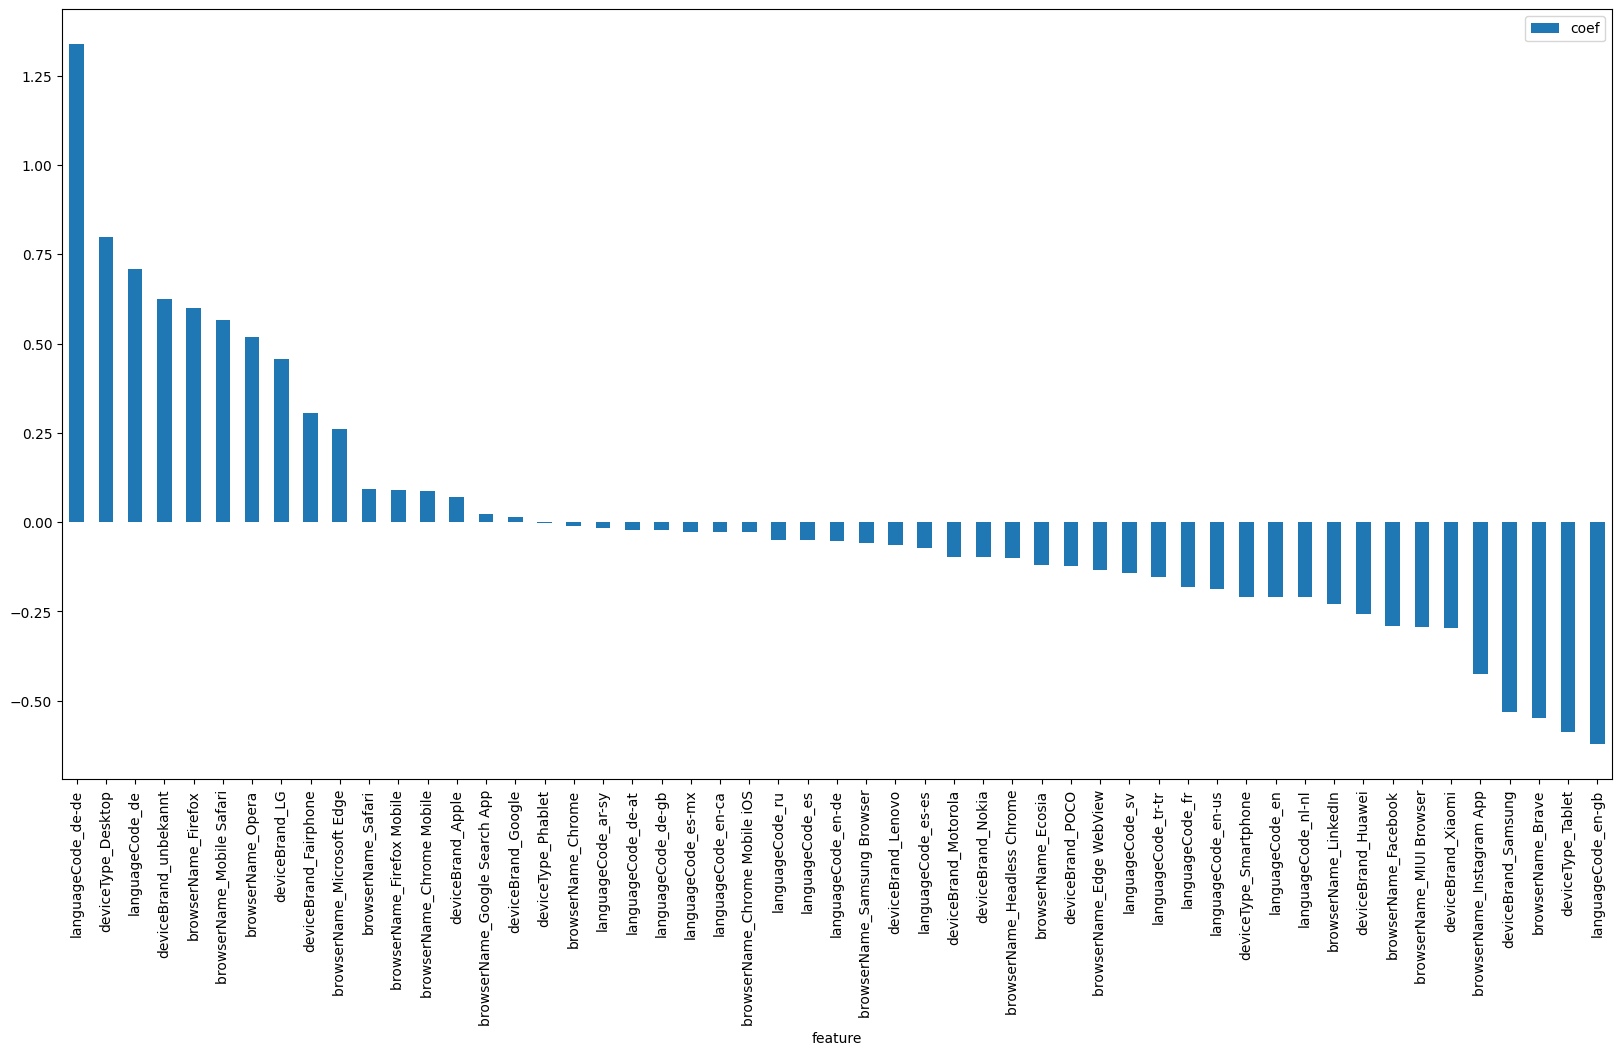

In [94]:
df_coef.plot(kind="bar", x="feature", y="coef", figsize=(20, 10))